## Dwell times analysis DNA vs Ribos runs

In [1]:
# import basic modules
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime

In [2]:
# ----- utils functions -----#
# def. aggregation function for samples
def agg_samples(x):
    '''
    Function to aggregate samples feature in the groupby operation
    merging all samples from the same event mapping onto a position
    into a unique list of float values 
    '''
    final = list( map(float, ",".join(x).split(",")))
    #final = ""
    #for e in x:
        #final += e
        #final += ","
        #final_list = final.rstrip(",").split(",")
        #final_map = list(map(float, final_list))
    return final


def is_rev_compl(seq1, seq2):
    '''
    Function to asses if two sequences are reverse complements.
    (for DNA)
    '''
    compl_dict = {"A":"T", "C":"G", "G":"C", "T":"A"}
    seq1_rev = seq1[::-1]
    seq1_rc = []
    for base in seq1_rev:
        seq1_rc.append(compl_dict[base])
    seq1_rc = "".join(seq1_rc)
    if seq1_rc == seq2:
        return True
    elif seq1_rc != seq2:
        return False
    

def collapse_eventalign(eventalign_filepath):
    '''
    Function to collapse on contig-position-ref_kmer-read_name the events from
    an eventalign file.
    '''
    df = pd.read_table(eventalign_filepath)
    # removing rows with NNNNNN model_kmer
    df = df[df["model_kmer"] != "NNNNNN"]
    df = df.groupby(["contig", "position", "reference_kmer", "read_name"]).agg({"samples":[agg_samples]})
    # resetting index and columns' names
    df = df.reset_index()
    df.columns = df.columns.droplevel(-1)
    df["event_level_mean"] = df["samples"].apply(np.mean)
    df["event_level_std"] = df["samples"].apply(np.std)
    df["dwell"] = df["samples"].apply(len).values
    df.drop("samples", axis=1, inplace=True)
    df.sort_values(["contig", "read_name"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


def produce_dweels_time_boxplots(comparison_title, labels, sites, ribos, dna_only_folder, ribo_folder, dna_only_eventalign_filename, ribo_eventalign_filename, interval=7):
    '''dwell times analysis. It produce:
        - box plot of regions (and save to these to files tiff)
        - plot of differences in dwell times between the two conditions (and save these to files tiff)
        - statistical analysis by two-sided Kolmogorov-Smirnov test (ad save it to files together with raw data)
    '''

    # create collapsed versions for each dataframes
    # DNA ONLY
    # forward strand
    dna_forward_eventalign_filepath = dna_eventalign_path + ".forw_strand"
    print(f"[{datetime.now()}] Collapsing events for {dna_forward_eventalign_filepath}", flush=True)
    dna_forward_eventalign = collapse_eventalign(dna_forward_eventalign_filepath)

    # reverse strand
    dna_reverse_eventalign_filepath = dna_eventalign_path + ".rev_strand"
    print(f"[{datetime.now()}] Collapsing events for {dna_reverse_eventalign_filepath}", flush=True)
    dna_reverse_eventalign = collapse_eventalign(dna_reverse_eventalign_filepath)

    # RIBO
    # forward strand
    ribo_forward_eventalign_filepath = ribo_eventalign_path + ".forw_strand"
    print(f"[{datetime.now()}] Collapsing events for {ribo_forward_eventalign_filepath}", flush=True)
    ribo_forward_eventalign = collapse_eventalign(ribo_forward_eventalign_filepath)

    # reverse strand
    ribo_reverse_eventalign_filepath = ribo_eventalign_path + ".rev_strand"
    print(f"[{datetime.now()}] Collapsing events for {ribo_reverse_eventalign_filepath}", flush=True)
    ribo_reverse_eventalign = collapse_eventalign(ribo_reverse_eventalign_filepath)

    # merge into uniq dataframes (forw and rev)
    df_forward_merged = pd.concat([dna_forward_eventalign, ribo_forward_eventalign], ignore_index=True)
    df_forward_merged["position"] = df_forward_merged["position"] + 1 # change to 1-based coordinate system since eventaling is 0-based
    df_forward_merged["y"] = [labels[0] for i in range(dna_forward_eventalign.shape[0])] + [labels[1] for i in range(ribo_forward_eventalign.shape[0])]

    df_reverse_merged = pd.concat([dna_reverse_eventalign, ribo_reverse_eventalign], ignore_index=True)
    df_reverse_merged["position"] = df_reverse_merged["position"] + 1 # change to 1-based coordinate system since eventaling is 0-based
    df_reverse_merged["y"] = [labels[0] for i in range(dna_reverse_eventalign.shape[0])] + [labels[1] for i in range(ribo_reverse_eventalign.shape[0])]
    
    print("\n FORWARD DNA-RIBO COLLAPSED")
    print(df_forward_merged)
    
    print("\n REVERSE DNA-RNA COLLAPSED")
    print(df_reverse_merged)
    print("\n\n")
    
    # grouping forward and reverse strand dwells statistics
    # group forward for statistics
    df_for_stats_dna = df_forward_merged.query(f"y=='{labels[0]}'").groupby("position").describe()[["dwell"]]
    df_for_stats_dna.columns = df_for_stats_dna.columns.droplevel()
    df_for_stats_dna.reset_index(inplace=True)
    df_for_stats_ribo = df_forward_merged.query(f"y=='{labels[1]}'").groupby("position").describe()[["dwell"]]
    df_for_stats_ribo.columns = df_for_stats_ribo.columns.droplevel()
    df_for_stats_ribo.reset_index(inplace=True)
    df_for_stats = pd.merge(df_for_stats_dna, df_for_stats_ribo, how="inner", on="position", suffixes=[f"_{labels[0]}", f"_{labels[1]}"])
    del(df_for_stats_dna)
    del(df_for_stats_ribo)
    # group reverse for statistics
    df_rev_stats_dna = df_reverse_merged.query(f"y=='{labels[0]}'").groupby("position").describe()[["dwell"]]
    df_rev_stats_dna.columns = df_rev_stats_dna.columns.droplevel()
    df_rev_stats_dna.reset_index(inplace=True)
    df_rev_stats_ribo = df_reverse_merged.query(f"y=='{labels[1]}'").groupby("position").describe()[["dwell"]]
    df_rev_stats_ribo.columns = df_rev_stats_ribo.columns.droplevel()
    df_rev_stats_ribo.reset_index(inplace=True)
    df_rev_stats = pd.merge(df_rev_stats_dna, df_rev_stats_ribo, how="inner", on="position", suffixes=[f"_{labels[0]}", f"_{labels[1]}"])
    del(df_rev_stats_dna)
    del(df_rev_stats_ribo)
    
    # save to disk the stats for both forward and reverse strands
    print(f"Saving df_for_stats to ", os.path.join(results_folder_path, f"{comparison_title}.dwell_stats.forw.tsv"))
    df_for_stats.to_csv(os.path.join(results_folder_path, f"{comparison_title}.dwell_stats.forw.tsv"), sep="\t")
          
    print(f"Saving df_rev_stats to ", os.path.join(results_folder_path, f"{comparison_title}.dwell_stats.rev.tsv"))
    df_rev_stats.to_csv(os.path.join(results_folder_path, f"{comparison_title}.dwell_stats.rev.tsv"), sep="\t")
    
    # plot dwells times
    # plot classic boxplot
    for site in sites:
        print(site)
        start = site - interval
        stop = site + interval
        title = comparison_title
        suptitle = f"M13mp18:{site}"
        # defining subplots
        f, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 9), sharex=True)

        # plot figure for forward strand on axes 1
        sn.boxplot(data=df_forward_merged.query(f"position >= {start} and position <= {stop}"), 
                  x="position", 
                  y="dwell", 
                  hue="y", 
                  #dodge=True,
                  #scale="width",
                  showfliers=False,
                  ax=axes[0])
        axes[0].set_title(title + ": Forward Strand")
        axes[0].set_ylabel("dwell time")
        axes[0].legend(loc="upper right")

        # plot figure for reverse strand on axes 2
        sn.boxplot(data=df_reverse_merged.query(f"position >= {start} and position <= {stop}"), 
                  x="position", 
                  y="dwell", 
                  hue="y", 
                  #dodge=True,
                  #scale="width",
                  showfliers=False,
                  ax=axes[1])

        axes[1].set_title(title + ": Reverse Strand")
        axes[1].set_ylabel("dwell time")
        axes[1].legend('', frameon=False)

        # change ylim
        max_ = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
        axes[0].set_ylim(0, max_)
        axes[1].set_ylim(0, max_)

        f.suptitle(suptitle, size=15, x=0.515, y=0.945)
        plt.savefig(os.path.join(results_folder_path, f"{title}-{suptitle}.tiff"), 
                    dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
        plt.show()
    
    

In [3]:
# define results folder path
results_folder_path = "/lustre/bio_running/DNA_Ribo/results/dwell_times_analysis_merged_stats"
# create folder if it doesn't exists
if not os.path.exists(results_folder_path):
    os.mkdir(results_folder_path)

## DNA vs Ribo1 - rep1

[2022-12-05 22:28:24.232704] Collapsing events for /lustre/bio_running/DNA_Ribo/run_dna_30062021/f5c_eval_wflags/dna_only_wflag_wholeprimer.eventalign.forw_strand
[2022-12-05 22:29:10.798400] Collapsing events for /lustre/bio_running/DNA_Ribo/run_dna_30062021/f5c_eval_wflags/dna_only_wflag_wholeprimer.eventalign.rev_strand
[2022-12-05 22:29:57.911809] Collapsing events for /lustre/bio_running/DNA_Ribo/run_1xRIBO_02072021/f5c_eval_wflags/run_1xRIBO_02072021_wflag_wholeprimer.eventalign.forw_strand
[2022-12-05 22:31:04.470300] Collapsing events for /lustre/bio_running/DNA_Ribo/run_1xRIBO_02072021/f5c_eval_wflags/run_1xRIBO_02072021_wflag_wholeprimer.eventalign.rev_strand

 FORWARD DNA-RIBO COLLAPSED
          contig  position reference_kmer  \
0        M13mp18      5022         AATATT   
1        M13mp18      4971         CGATGT   
2        M13mp18      4972         GATGTT   
3        M13mp18      4973         ATGTTT   
4        M13mp18      4974         TGTTTT   
...          ...       

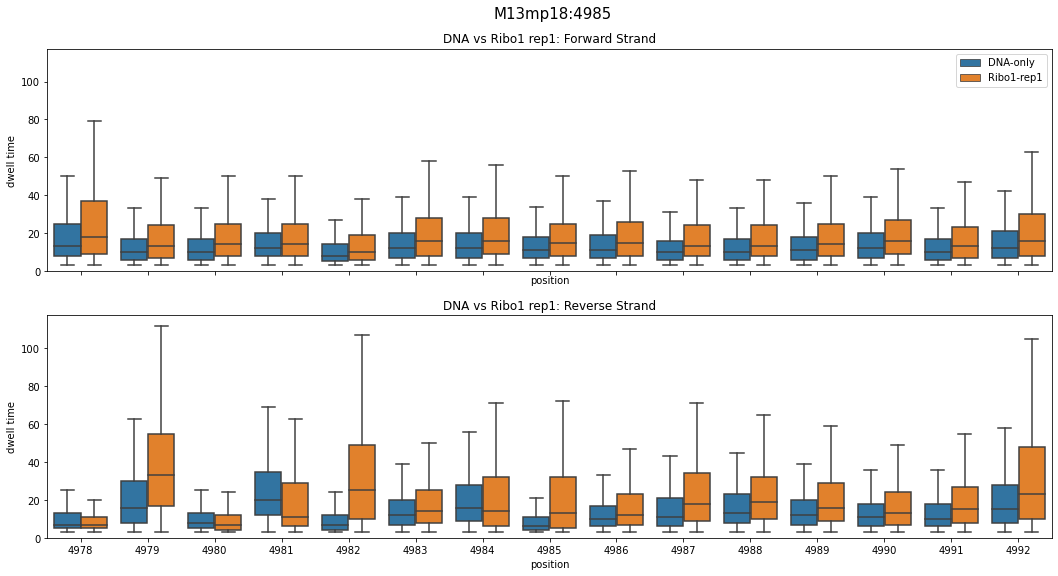

4997


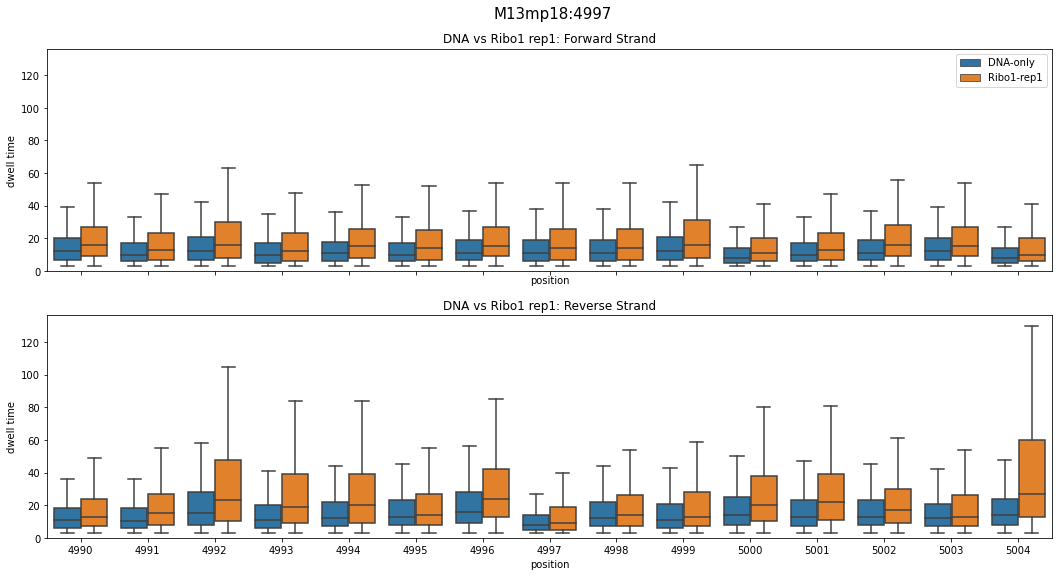

5004


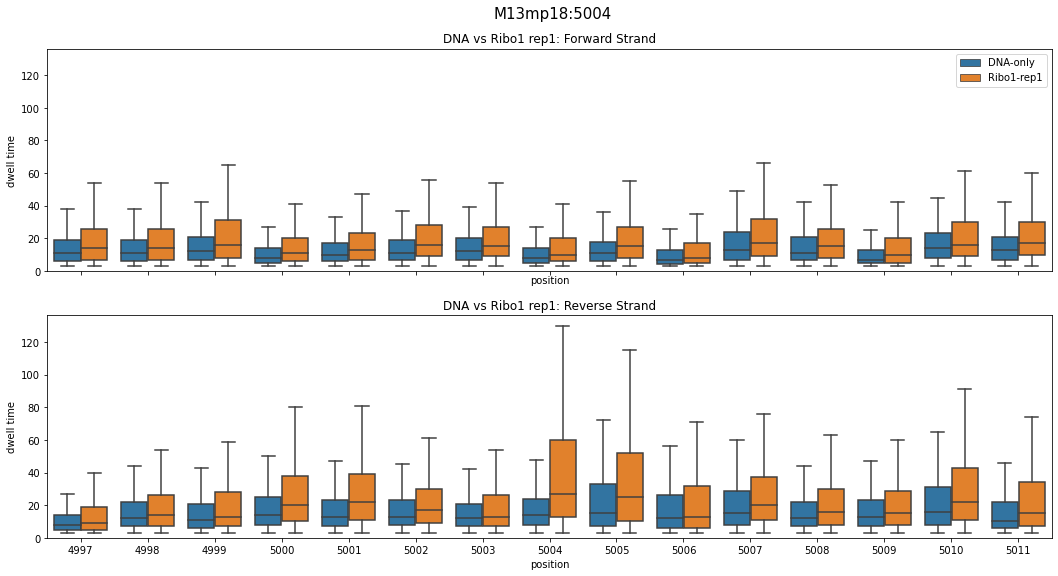

5015


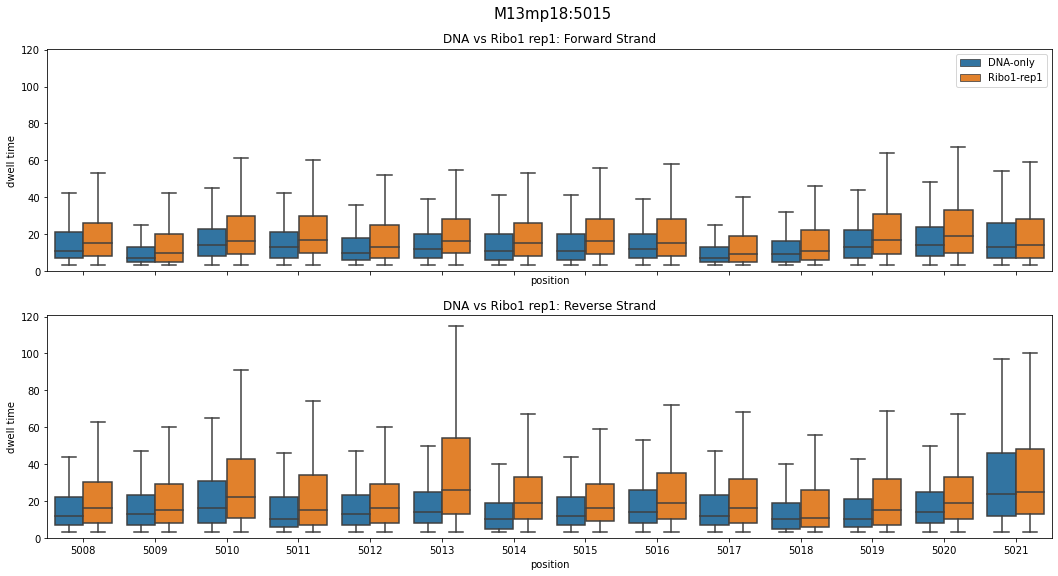

In [4]:
comparison_title = "DNA vs Ribo1 rep1"
labels = ["DNA-only", "Ribo1-rep1"]

# define expected sites with ribonucleotides insertion on reverse strand
sites = [4985, 4997, 5004, 5015]

# define ribo names into a list
ribos = ["rA", "rG", "rC", "U"]

# ----- defining basic input paths -----#
dna_only_folder = "/lustre/bio_running/DNA_Ribo/run_dna_30062021"
ribo_folder = "/lustre/bio_running/DNA_Ribo/run_1xRIBO_02072021"

dna_only_eventalign_filename = "dna_only_wflag_wholeprimer.eventalign"
ribo_eventalign_filename = "run_1xRIBO_02072021_wflag_wholeprimer.eventalign"

dna_eventalign_path = os.path.join(dna_only_folder, "f5c_eval_wflags", dna_only_eventalign_filename)
ribo_eventalign_path = os.path.join(ribo_folder, "f5c_eval_wflags", ribo_eventalign_filename)

produce_dweels_time_boxplots(comparison_title, labels, sites, ribos, 
                             dna_only_folder, ribo_folder, 
                             dna_only_eventalign_filename, ribo_eventalign_filename)

4985 rA


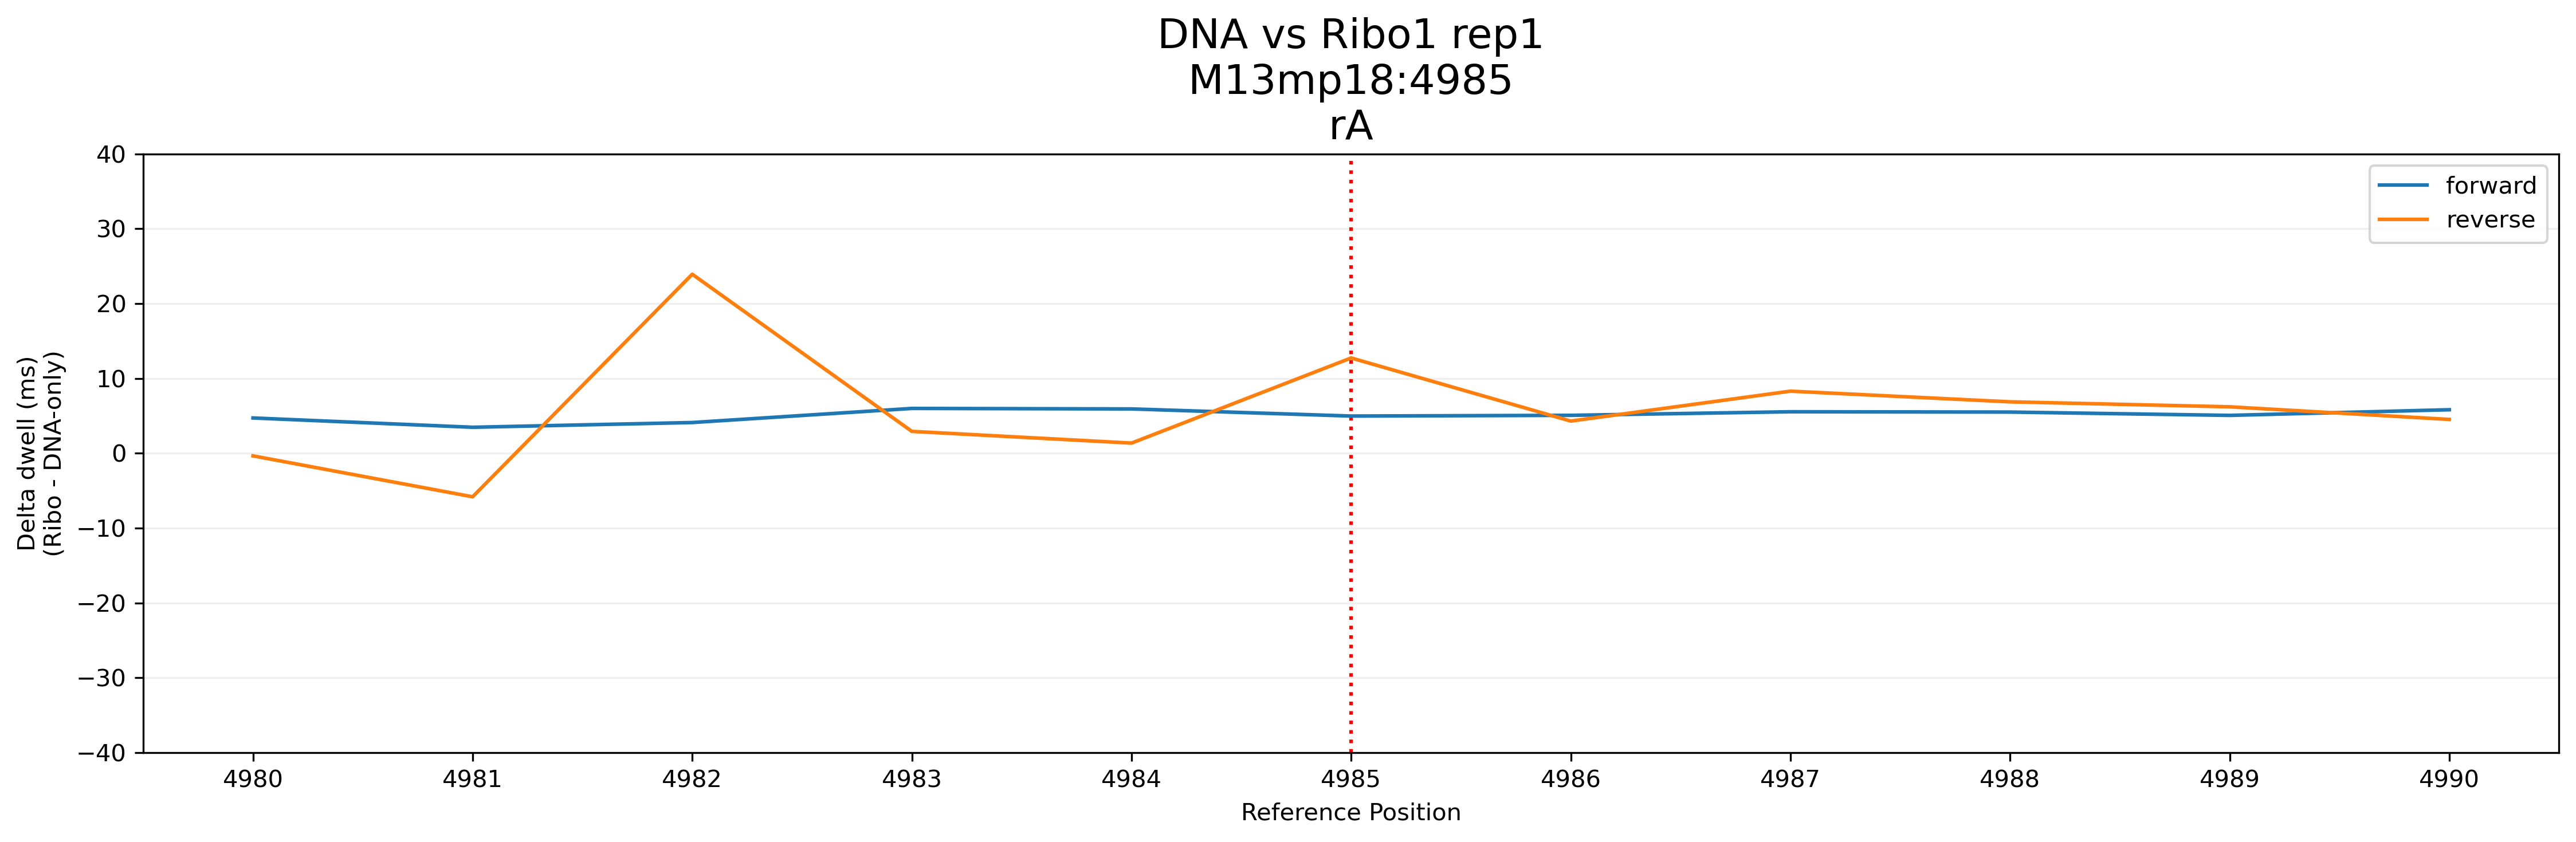

4997 rG


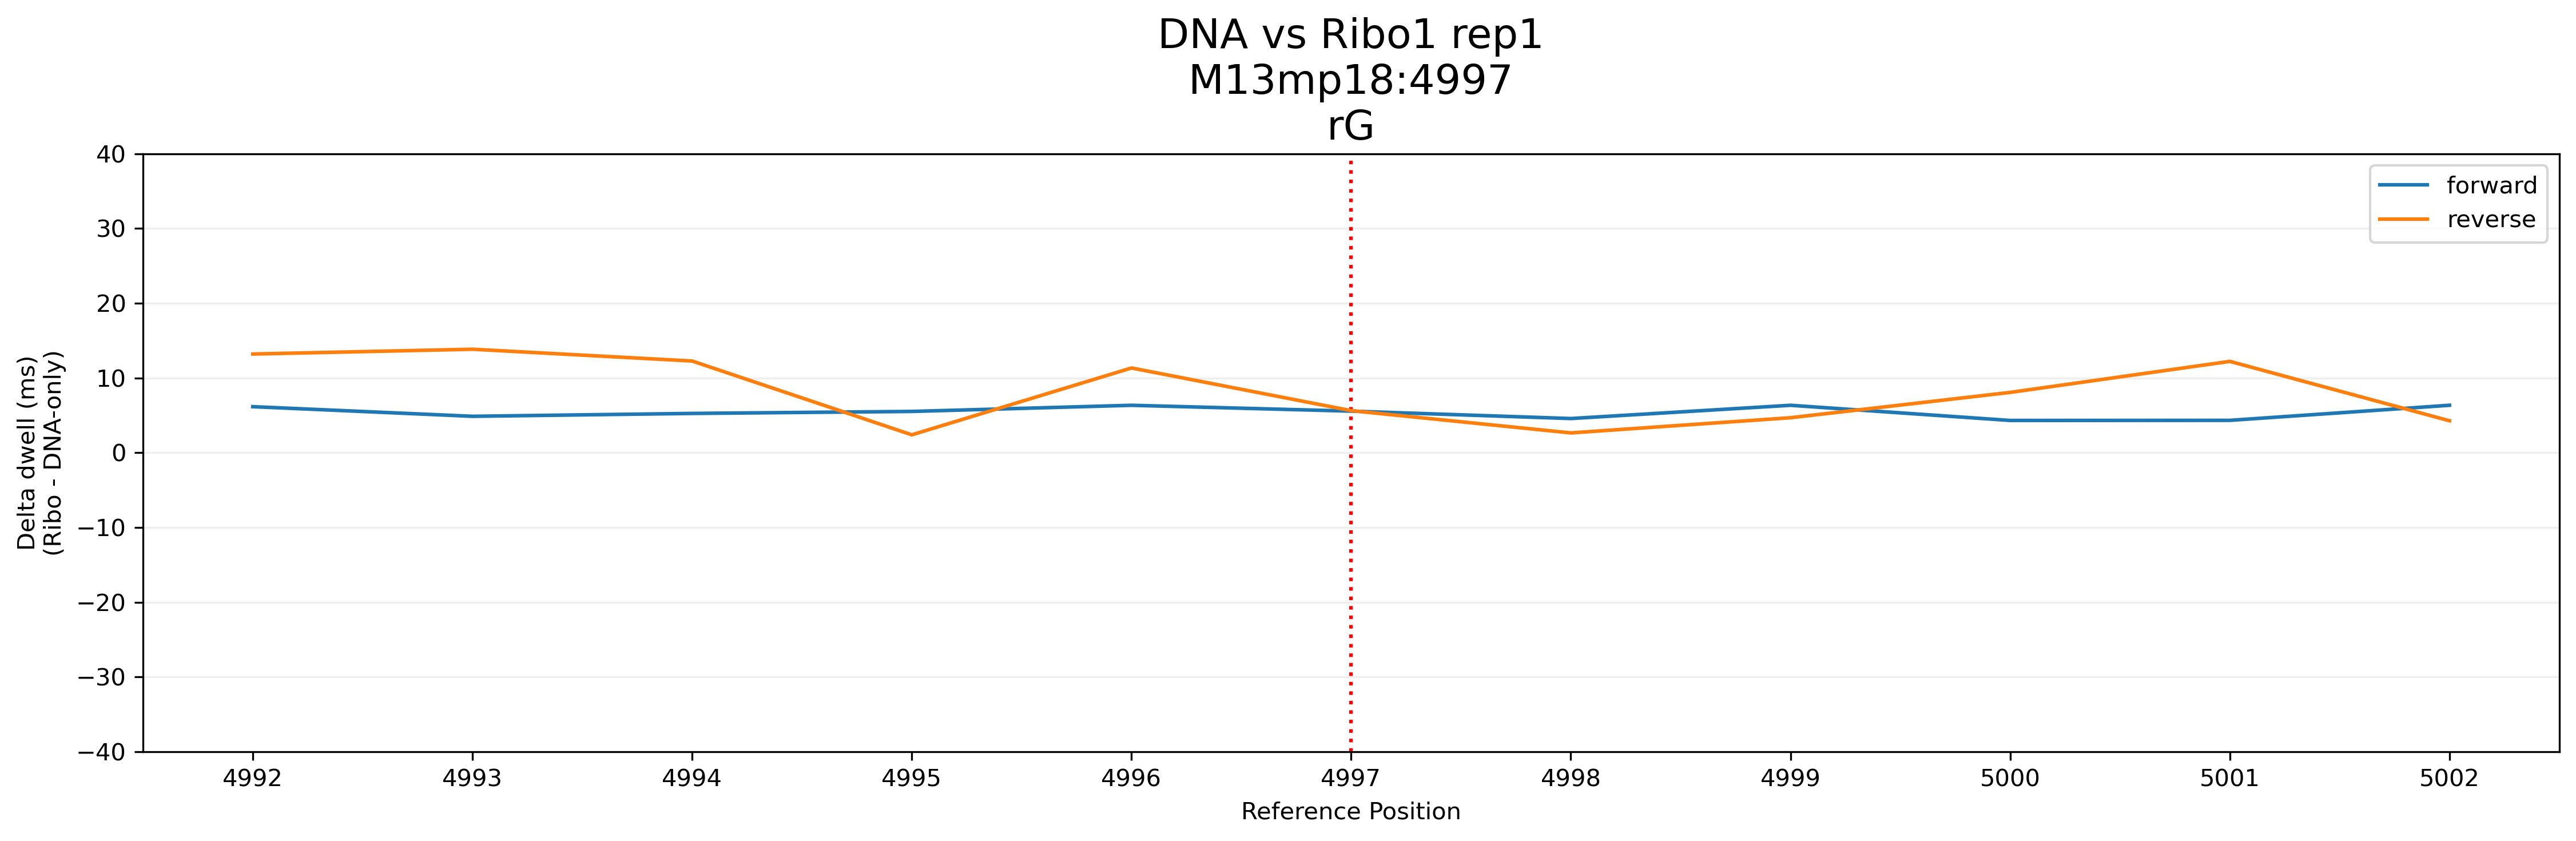

5004 rC


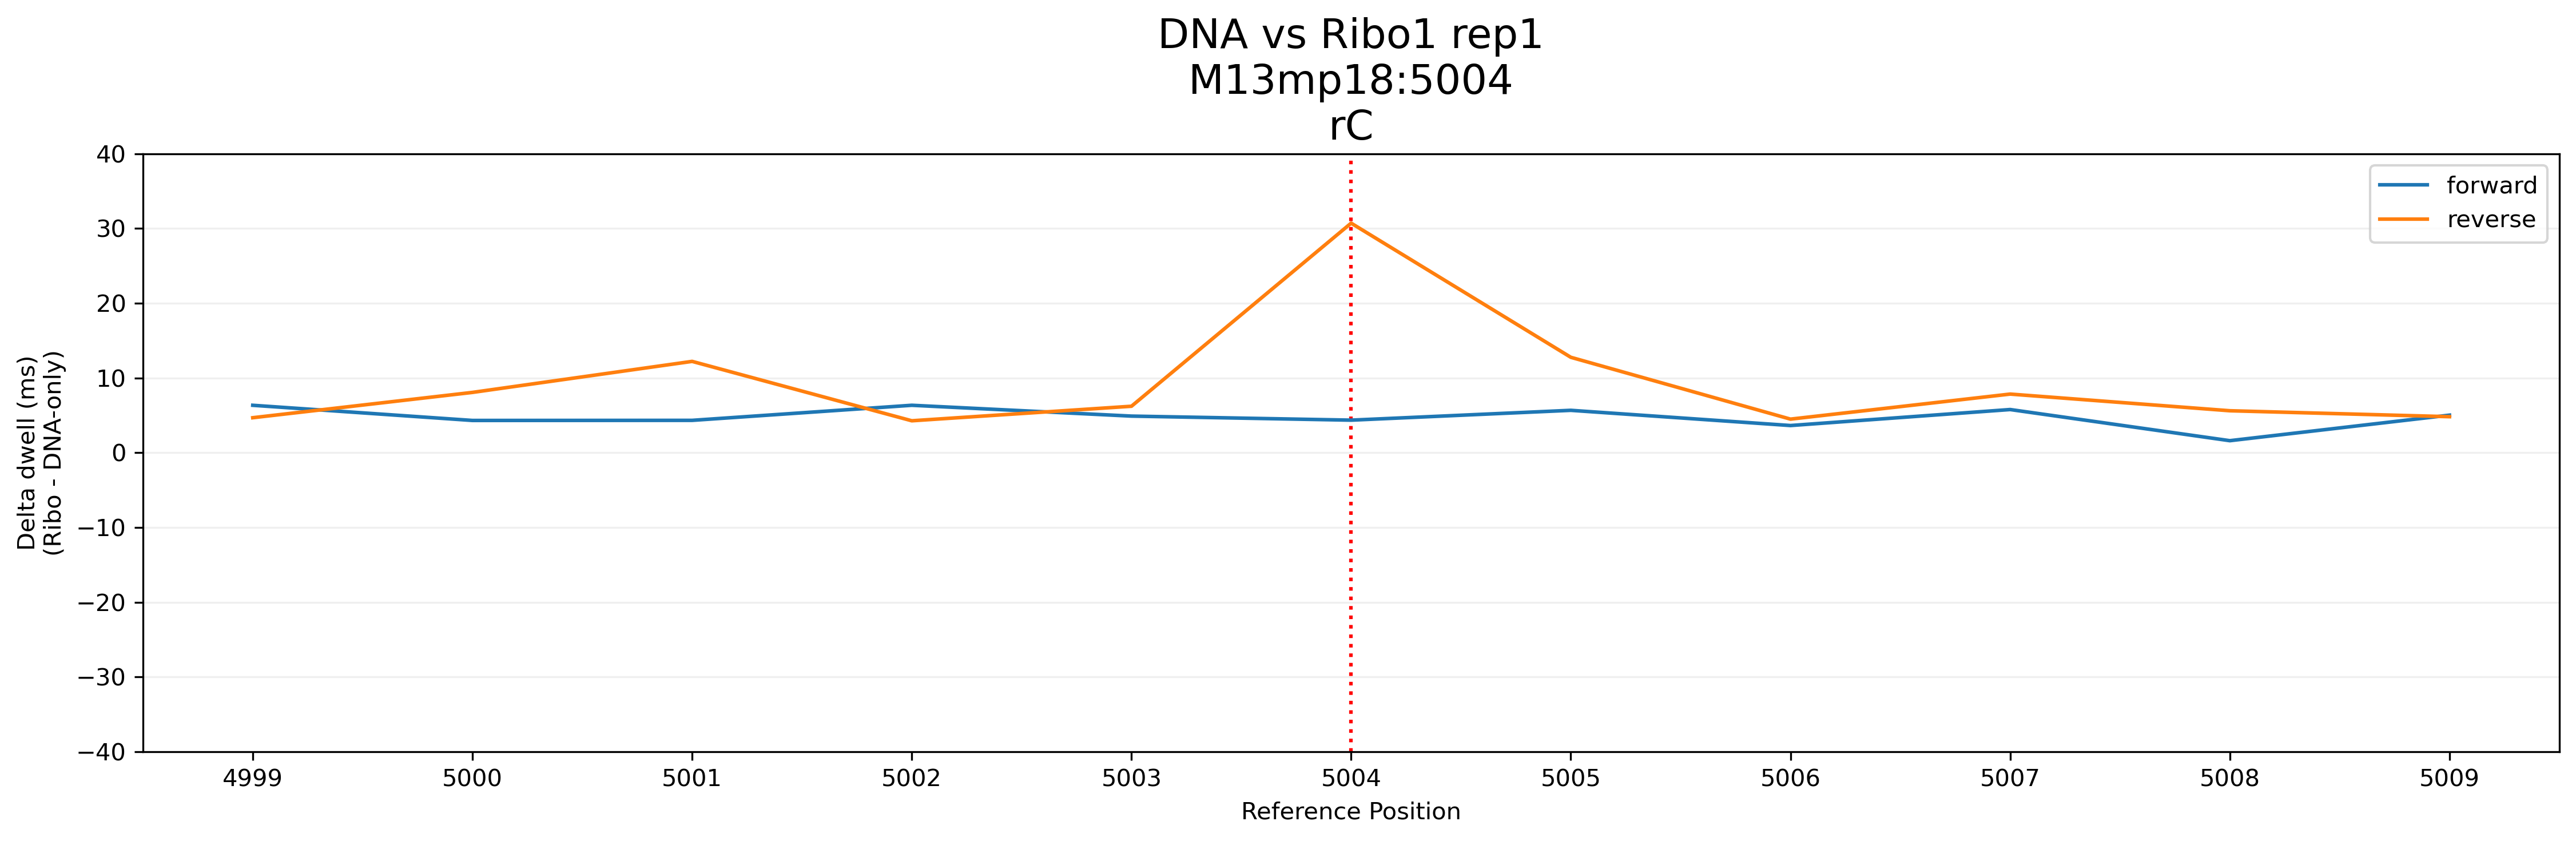

5015 U


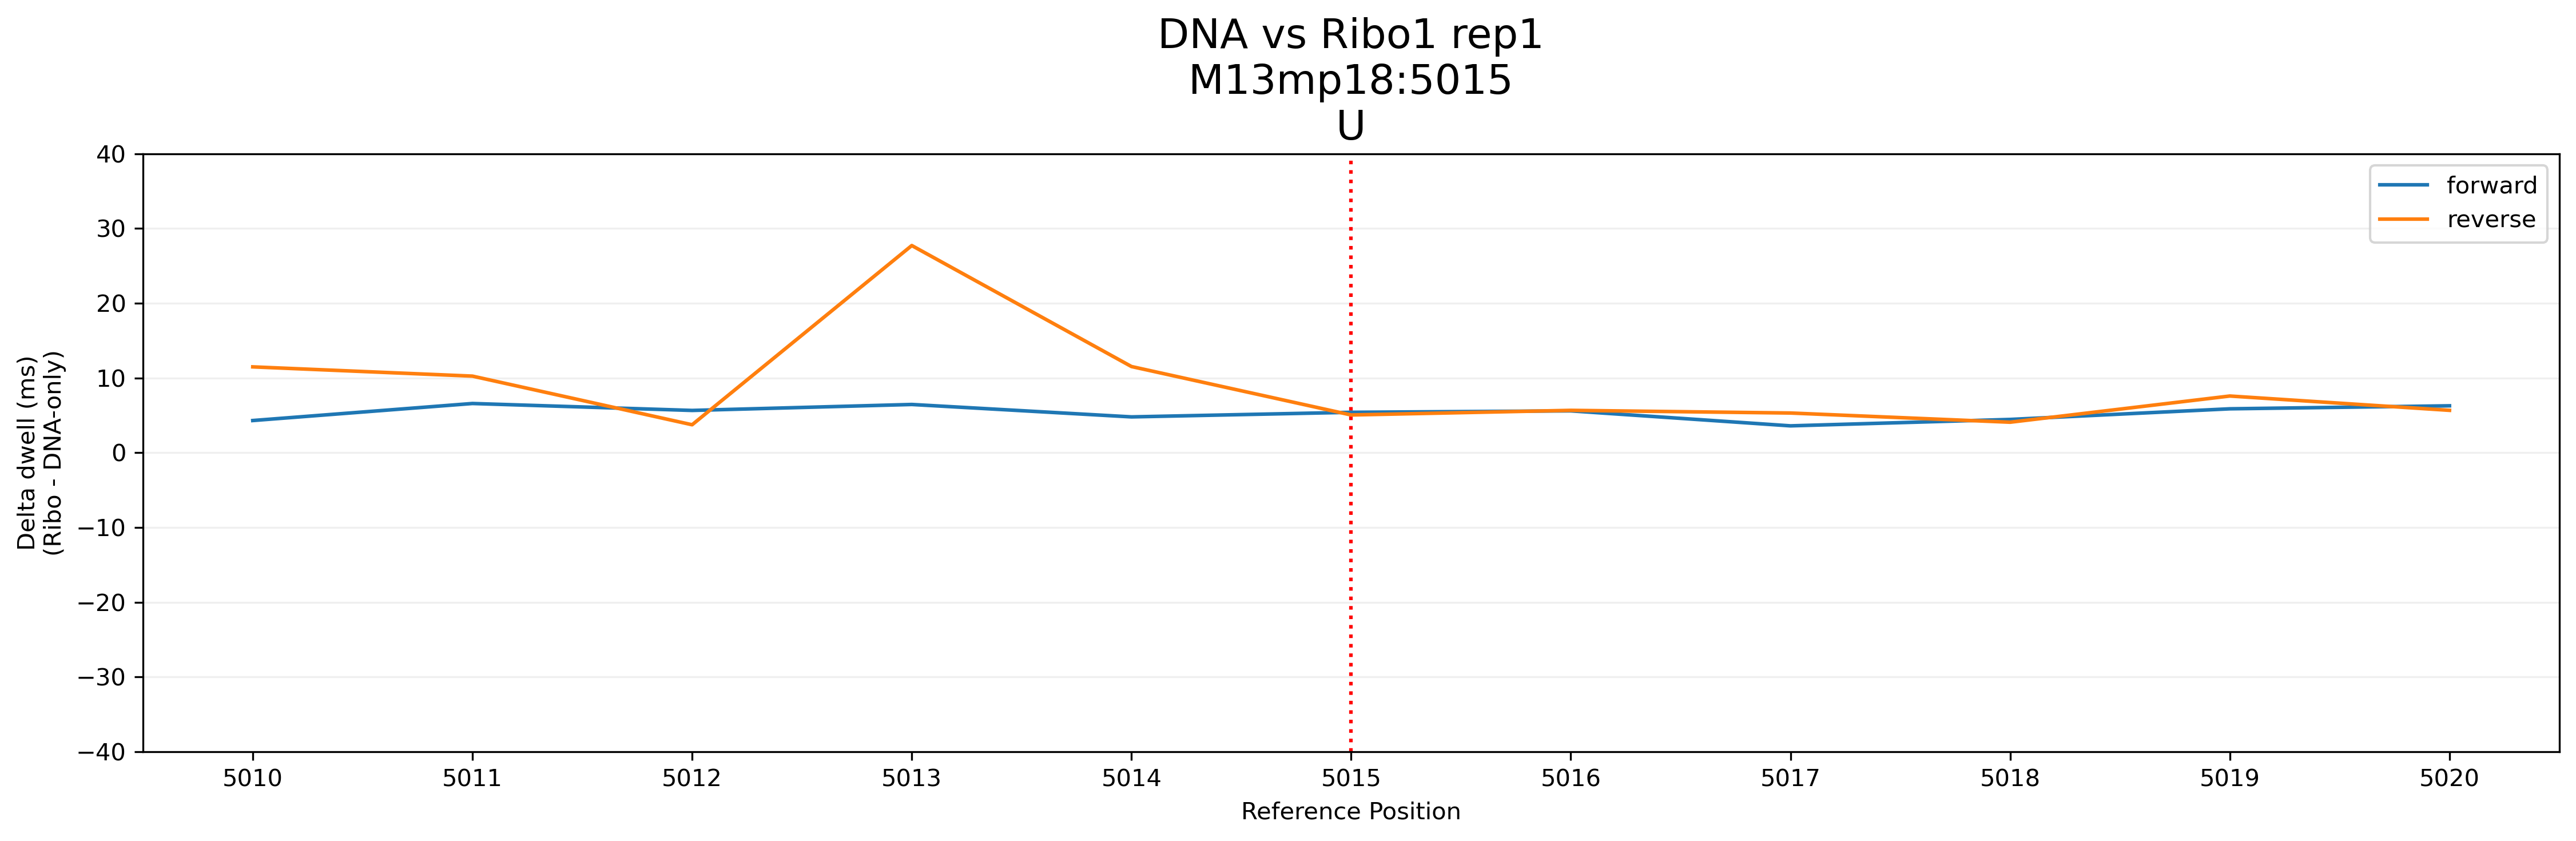

In [5]:
# produce differenial plot for dwell time
comparison_title = "DNA vs Ribo1 rep1"
labels = ["DNA-only", "Ribo1-rep1"]

# define expected sites with ribonucleotides insertion on reverse strand
sites = [4985, 4997, 5004, 5015]

# define ribo names into a list
ribos = ["rA", "rG", "rC", "U"]
# load stats tables
df_for = pd.read_table(os.path.join(results_folder_path, comparison_title+".dwell_stats.forw.tsv"), index_col=0)
df_for = df_for.iloc[:,[0,2,10]]
df_for["delta_forw"] = df_for.iloc[:,2] - df_for.iloc[:,1]

df_rev = pd.read_table(os.path.join(results_folder_path, comparison_title+".dwell_stats.rev.tsv"), index_col=0)
df_rev = df_rev.iloc[:,[0,2,10]]
df_rev["delta_rev"] = df_rev.iloc[:,2] - df_rev.iloc[:,1]

df_delta_global = pd.merge(df_for[["position", "delta_forw"]], df_rev[["position", "delta_rev"]], how="inner", on="position")

for site, ribo in zip(sites, ribos):
    print(site, ribo)
    interval = 5
    start = site - interval
    stop = site + interval
    title = comparison_title
    suptitle = f"M13mp18:{site}"
    df_delta = df_delta_global.query(f"position >= {start} and position <= {stop}")
    # plot resulting delta plot
    f = plt.figure(figsize=(15,5), dpi=300)
    plt.plot(df_delta["position"], df_delta["delta_forw"], label="forward")
    plt.plot(df_delta["position"], df_delta["delta_rev"], label="reverse")
    plt.legend()
    plt.title(comparison_title + "\n" + suptitle + "\n" + ribo , fontsize="xx-large")
    plt.xlabel("Reference Position")
    plt.ylabel("Delta dwell (ms)\n(Ribo - DNA-only)")
    plt.tight_layout()
    plt.xticks(np.arange(df_delta.position.min(), df_delta.position.max()+1,1))
    # plot vline for ribo
    plt.ylim(-40,+40)
    plt.vlines(site, -40, +40, linestyles="dotted", color="red")
    plt.grid(axis='y', alpha=0.2)
    # save to tiff
    plt.savefig(os.path.join(results_folder_path, f"{title}-{suptitle}.delta.tiff"), 
                    dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()

## DNA vs Ribo1 - rep2

[2022-12-05 23:20:27.551774] Collapsing events for /lustre/bio_running/DNA_Ribo/run_dna_30062021/f5c_eval_wflags/dna_only_wflag_wholeprimer.eventalign.forw_strand
[2022-12-05 23:21:12.244719] Collapsing events for /lustre/bio_running/DNA_Ribo/run_dna_30062021/f5c_eval_wflags/dna_only_wflag_wholeprimer.eventalign.rev_strand
[2022-12-05 23:21:59.750102] Collapsing events for /lustre/bio_running/DNA_Ribo/run_1xRIBO_09072021/f5c_eval_wflags/run_1xRIBO_09072021_wflag_wholeprimer.eventalign.forw_strand
[2022-12-05 23:42:24.452234] Collapsing events for /lustre/bio_running/DNA_Ribo/run_1xRIBO_09072021/f5c_eval_wflags/run_1xRIBO_09072021_wflag_wholeprimer.eventalign.rev_strand

 FORWARD DNA-RIBO COLLAPSED
           contig  position reference_kmer  \
0         M13mp18      5022         AATATT   
1         M13mp18      4971         CGATGT   
2         M13mp18      4972         GATGTT   
3         M13mp18      4973         ATGTTT   
4         M13mp18      4974         TGTTTT   
...           ...

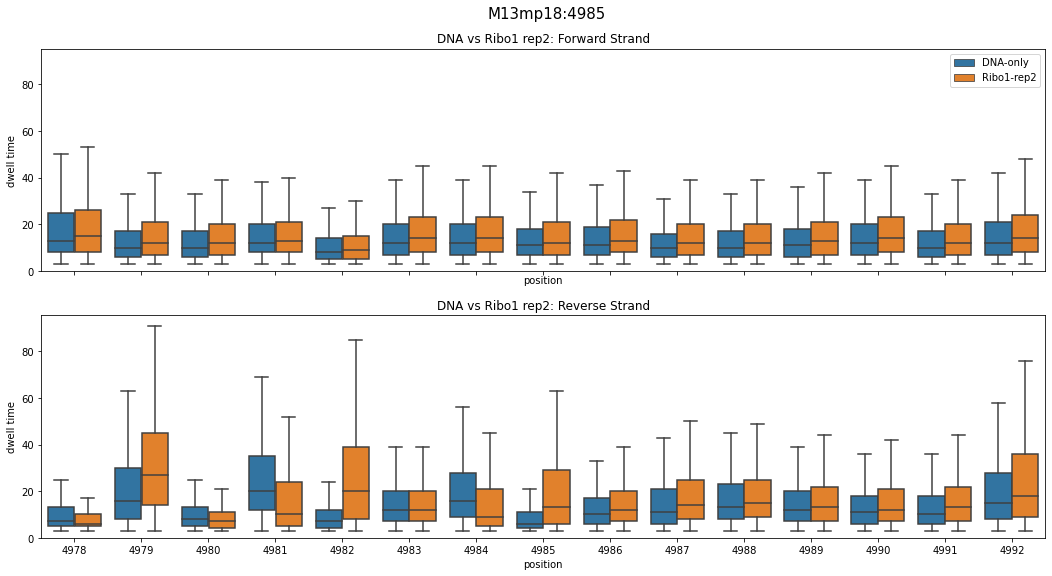

4997


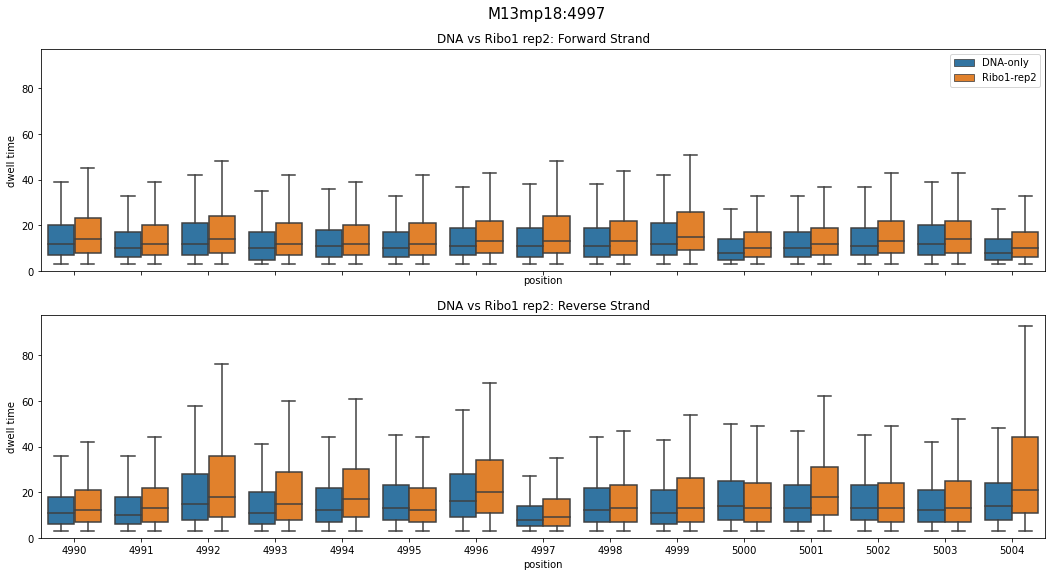

5004


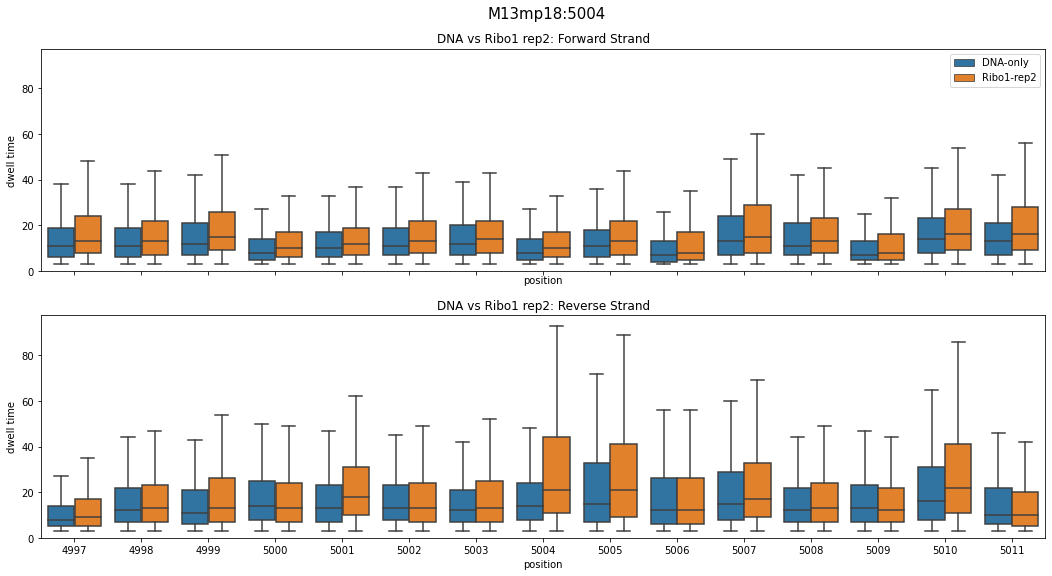

5015


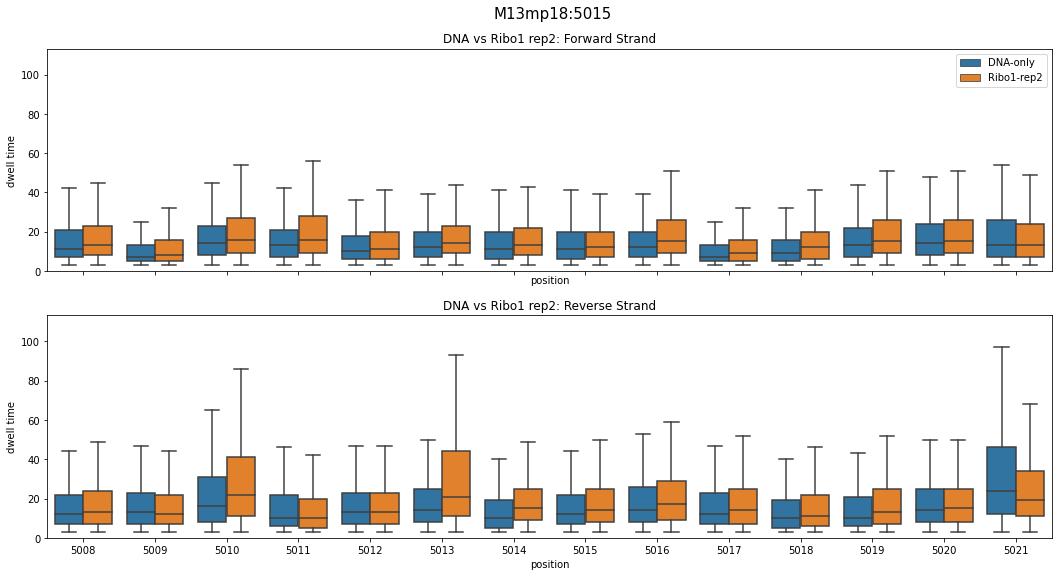

In [10]:
comparison_title = "DNA vs Ribo1 rep2"
labels = ["DNA-only", "Ribo1-rep2"]

# define expected sites with ribonucleotides insertion on reverse strand
sites = [4985, 4997, 5004, 5015]

# define ribo names into a list
ribos = ["rA", "rG", "rC", "U"]

# ----- defining basic input paths -----#
dna_only_folder = "/lustre/bio_running/DNA_Ribo/run_dna_30062021"
ribo_folder = "/lustre/bio_running/DNA_Ribo/run_1xRIBO_09072021"

dna_only_eventalign_filename = "dna_only_wflag_wholeprimer.eventalign"
ribo_eventalign_filename = "run_1xRIBO_09072021_wflag_wholeprimer.eventalign"

dna_eventalign_path = os.path.join(dna_only_folder, "f5c_eval_wflags", dna_only_eventalign_filename)
ribo_eventalign_path = os.path.join(ribo_folder, "f5c_eval_wflags", ribo_eventalign_filename)

produce_dweels_time_boxplots(comparison_title, labels, sites, ribos,
                             dna_only_folder, ribo_folder, 
                             dna_only_eventalign_filename, ribo_eventalign_filename)

4985 rA


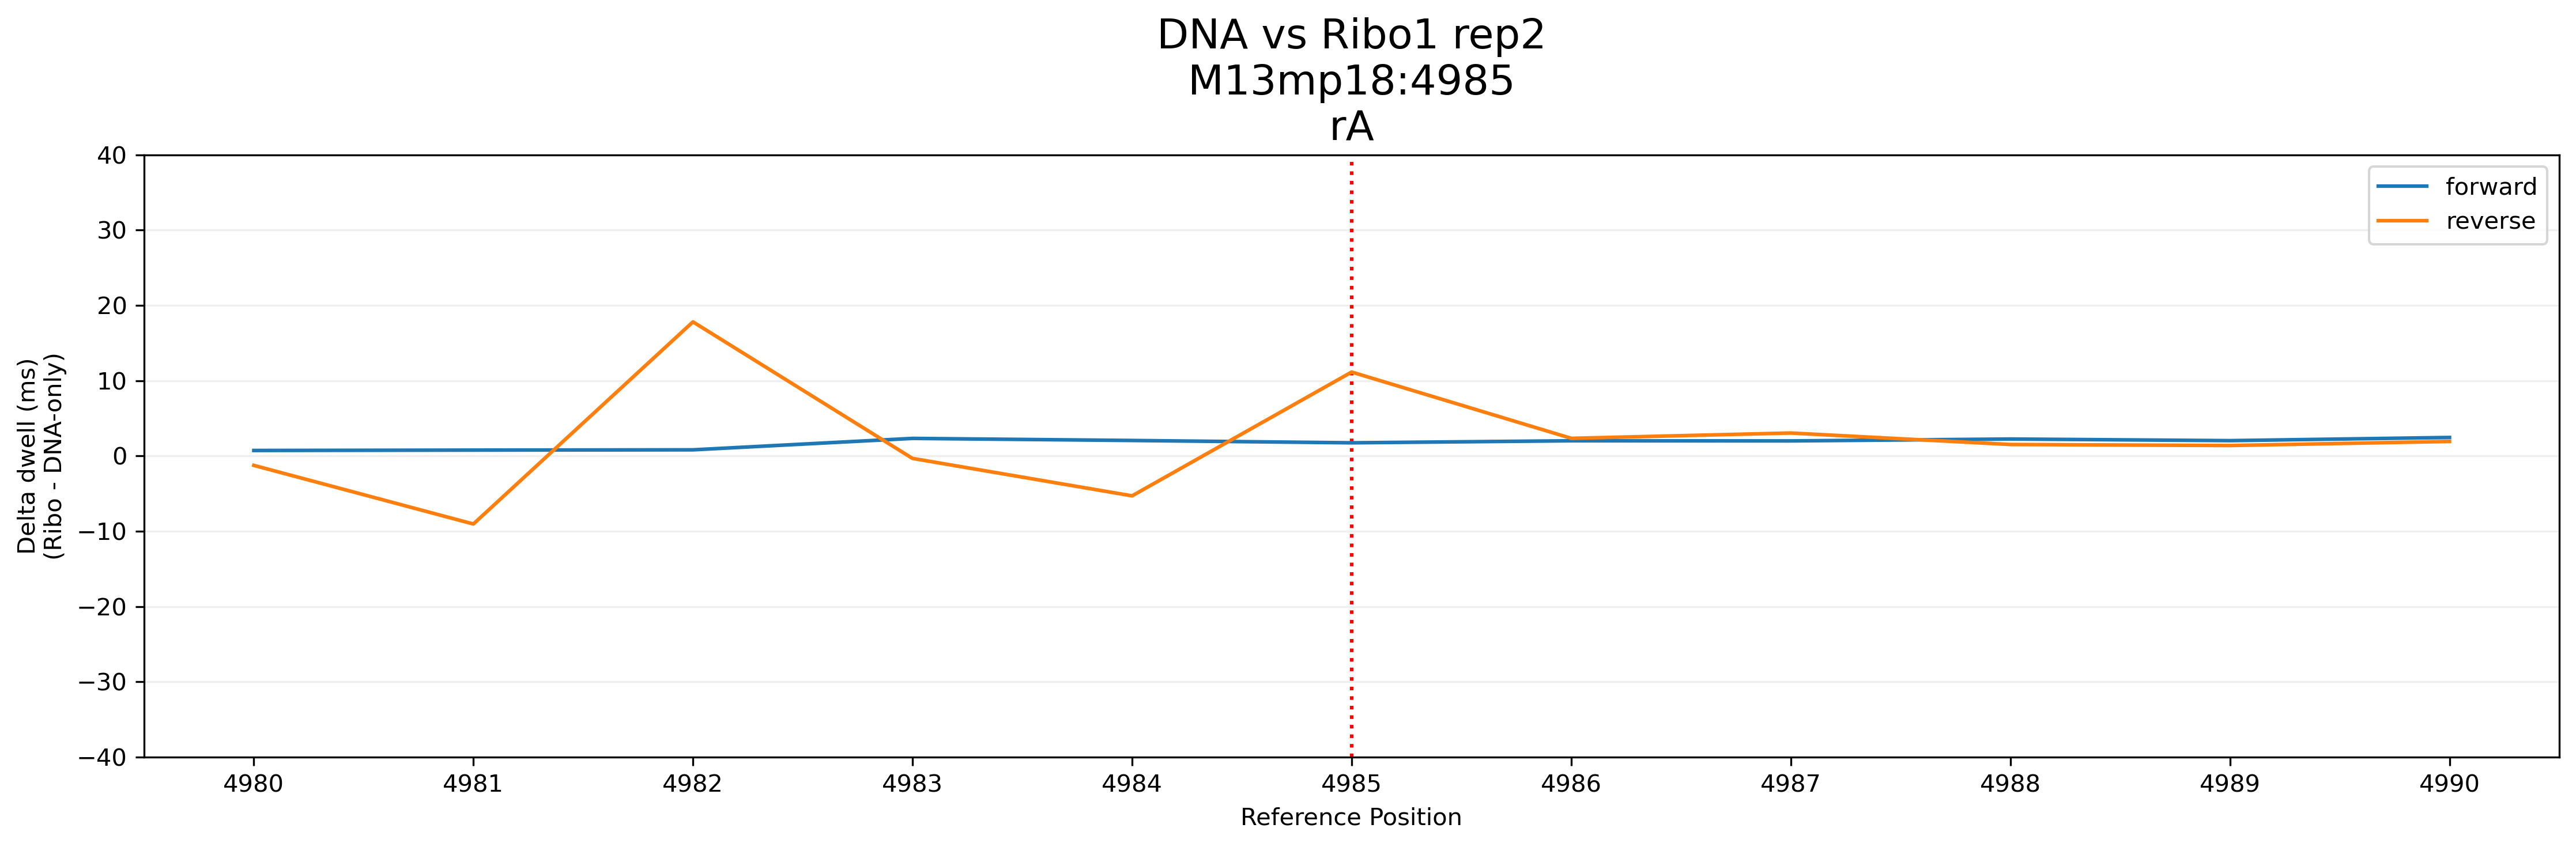

4997 rG


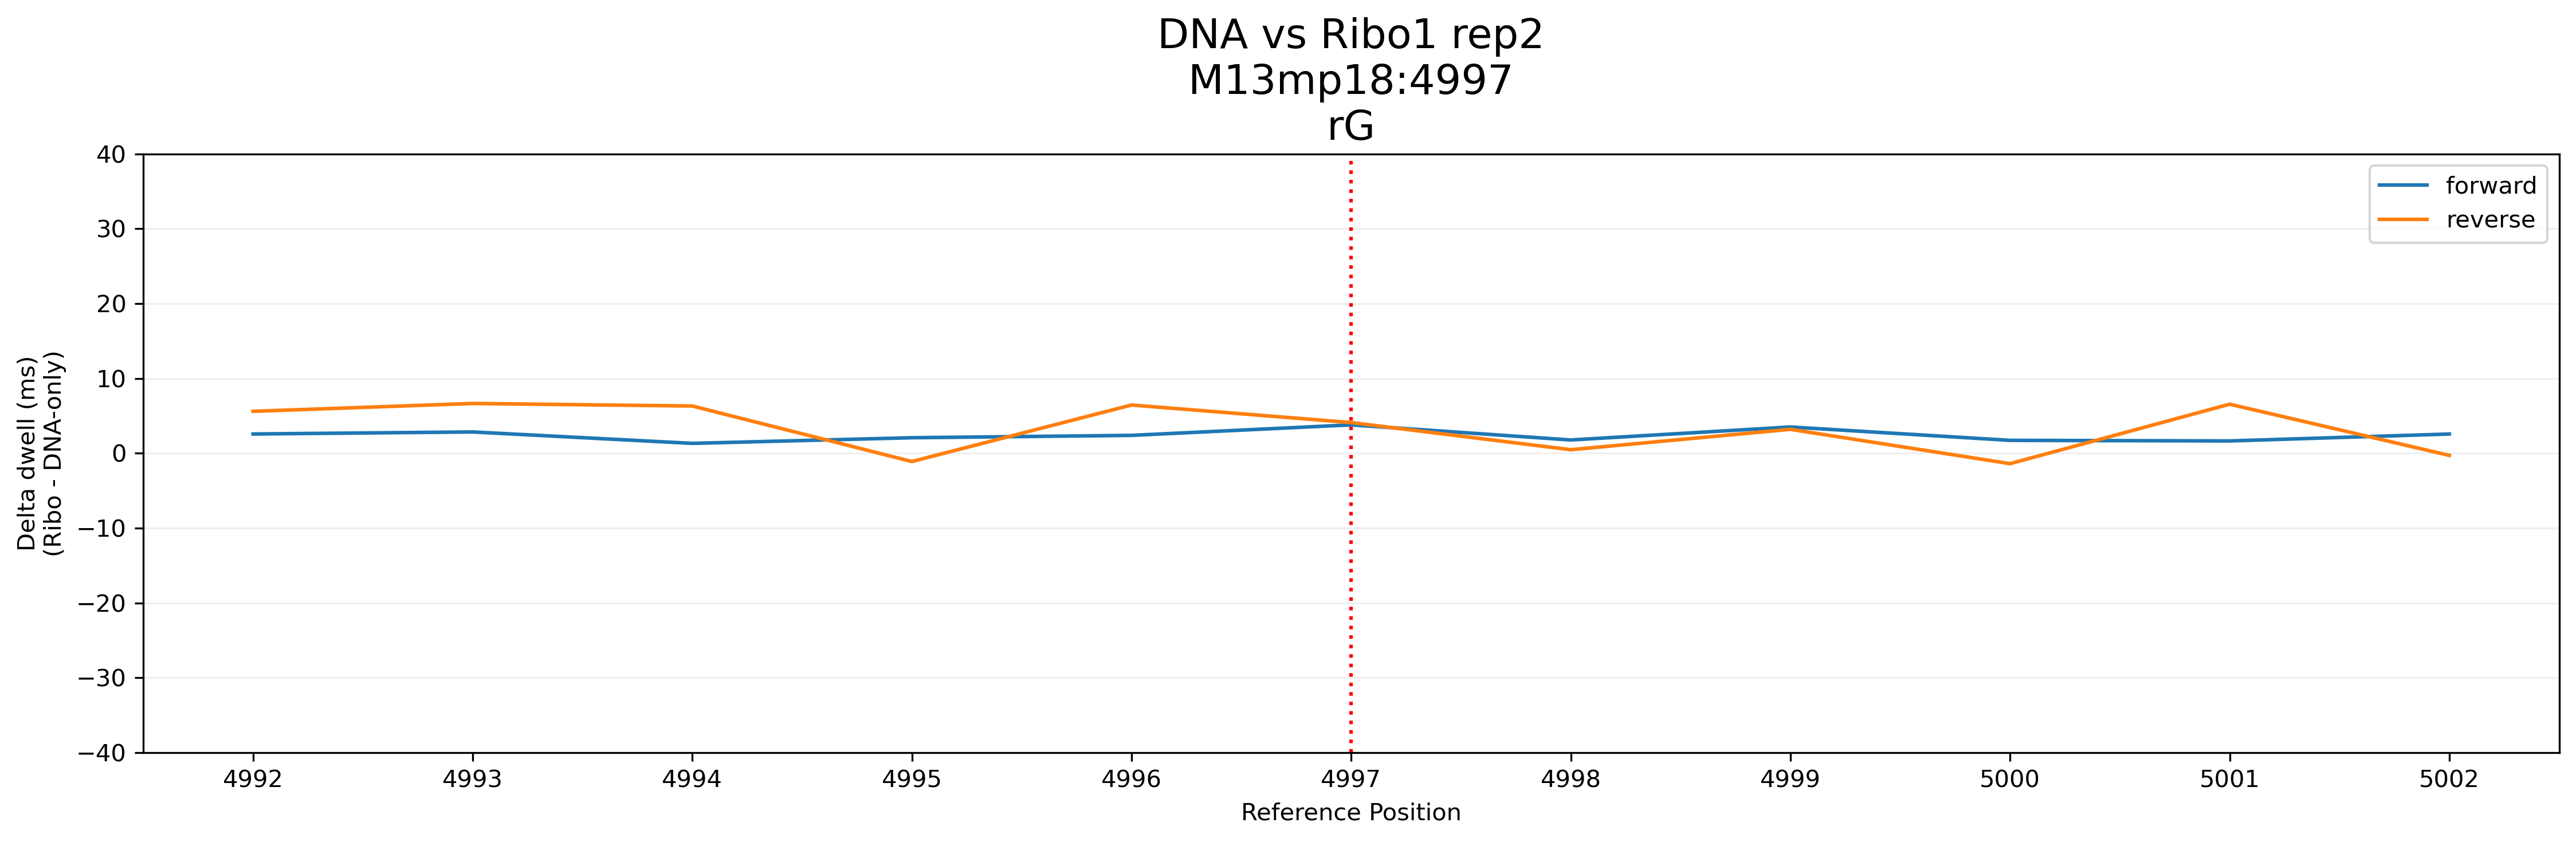

5004 rC


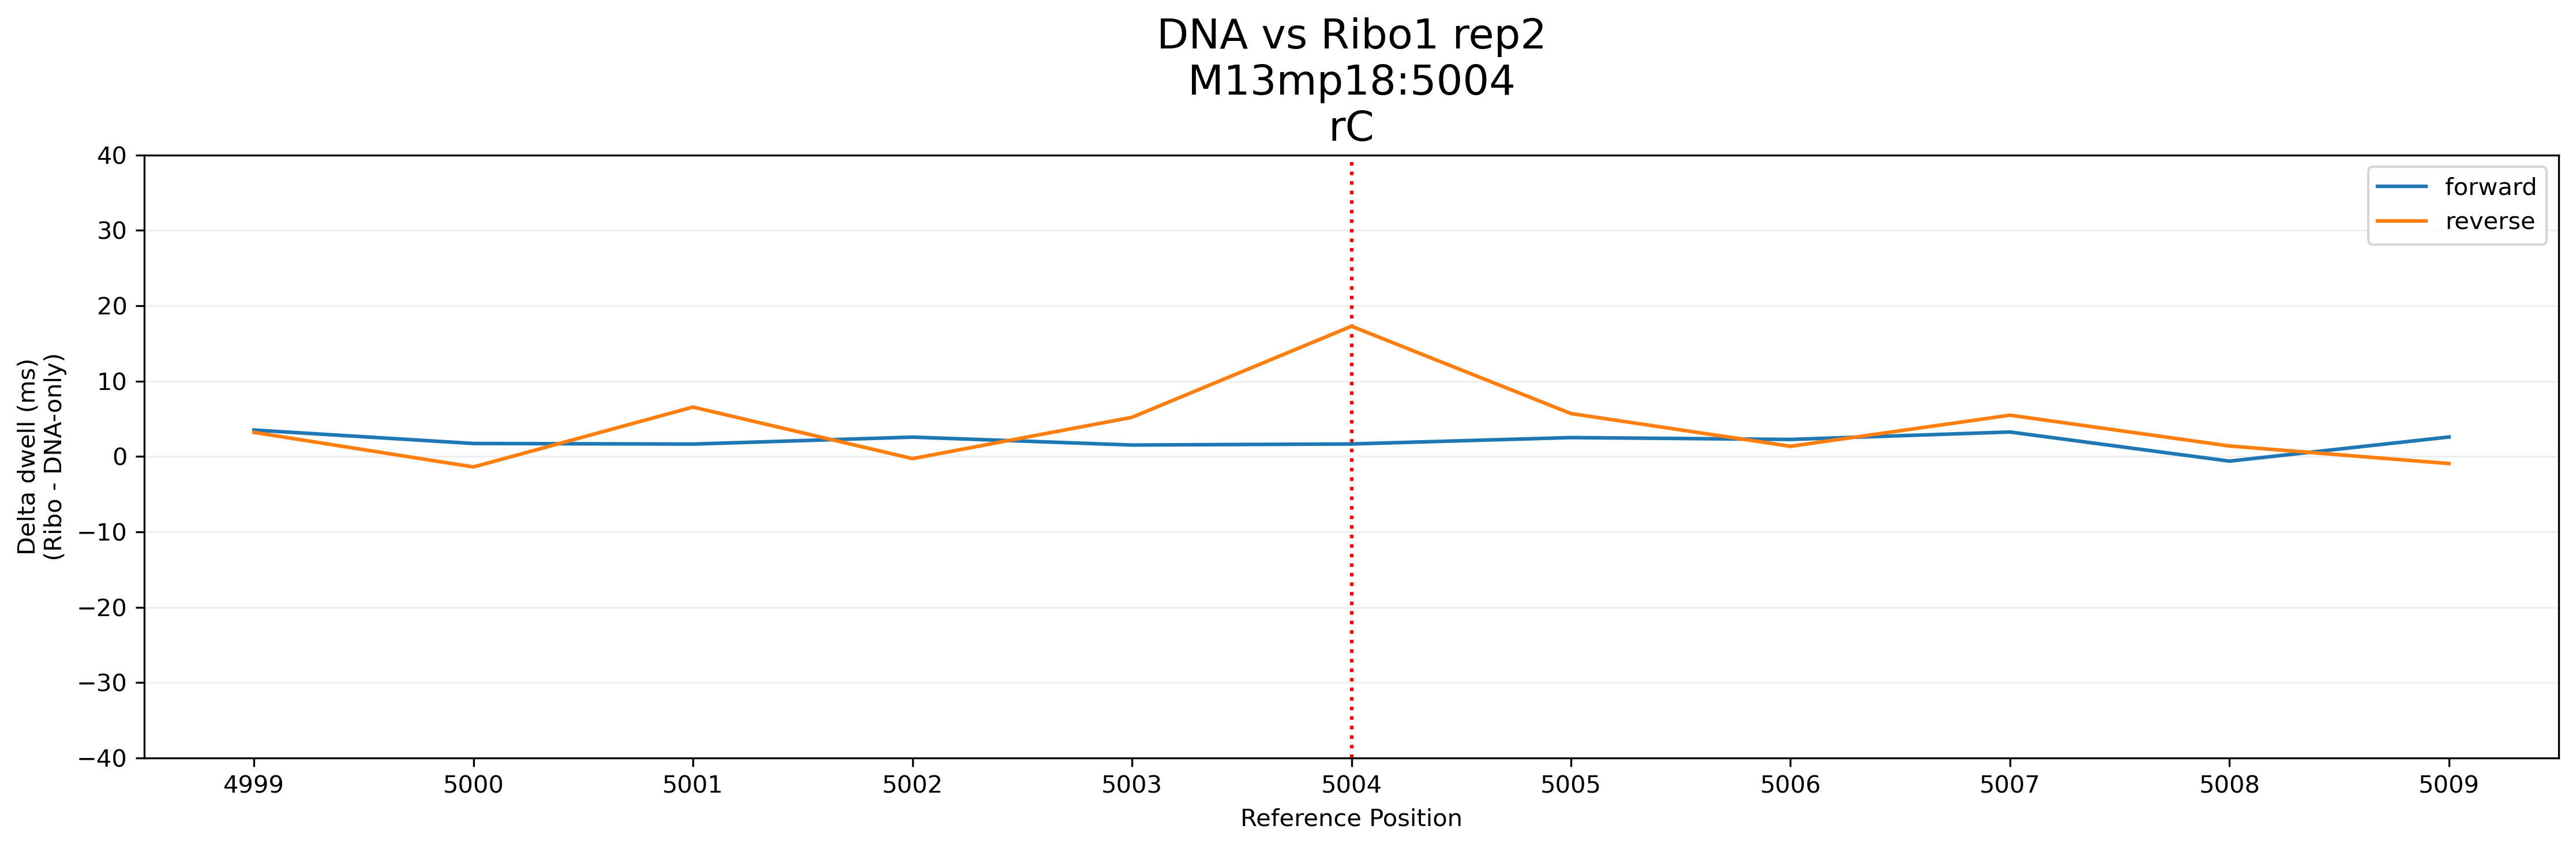

5015 U


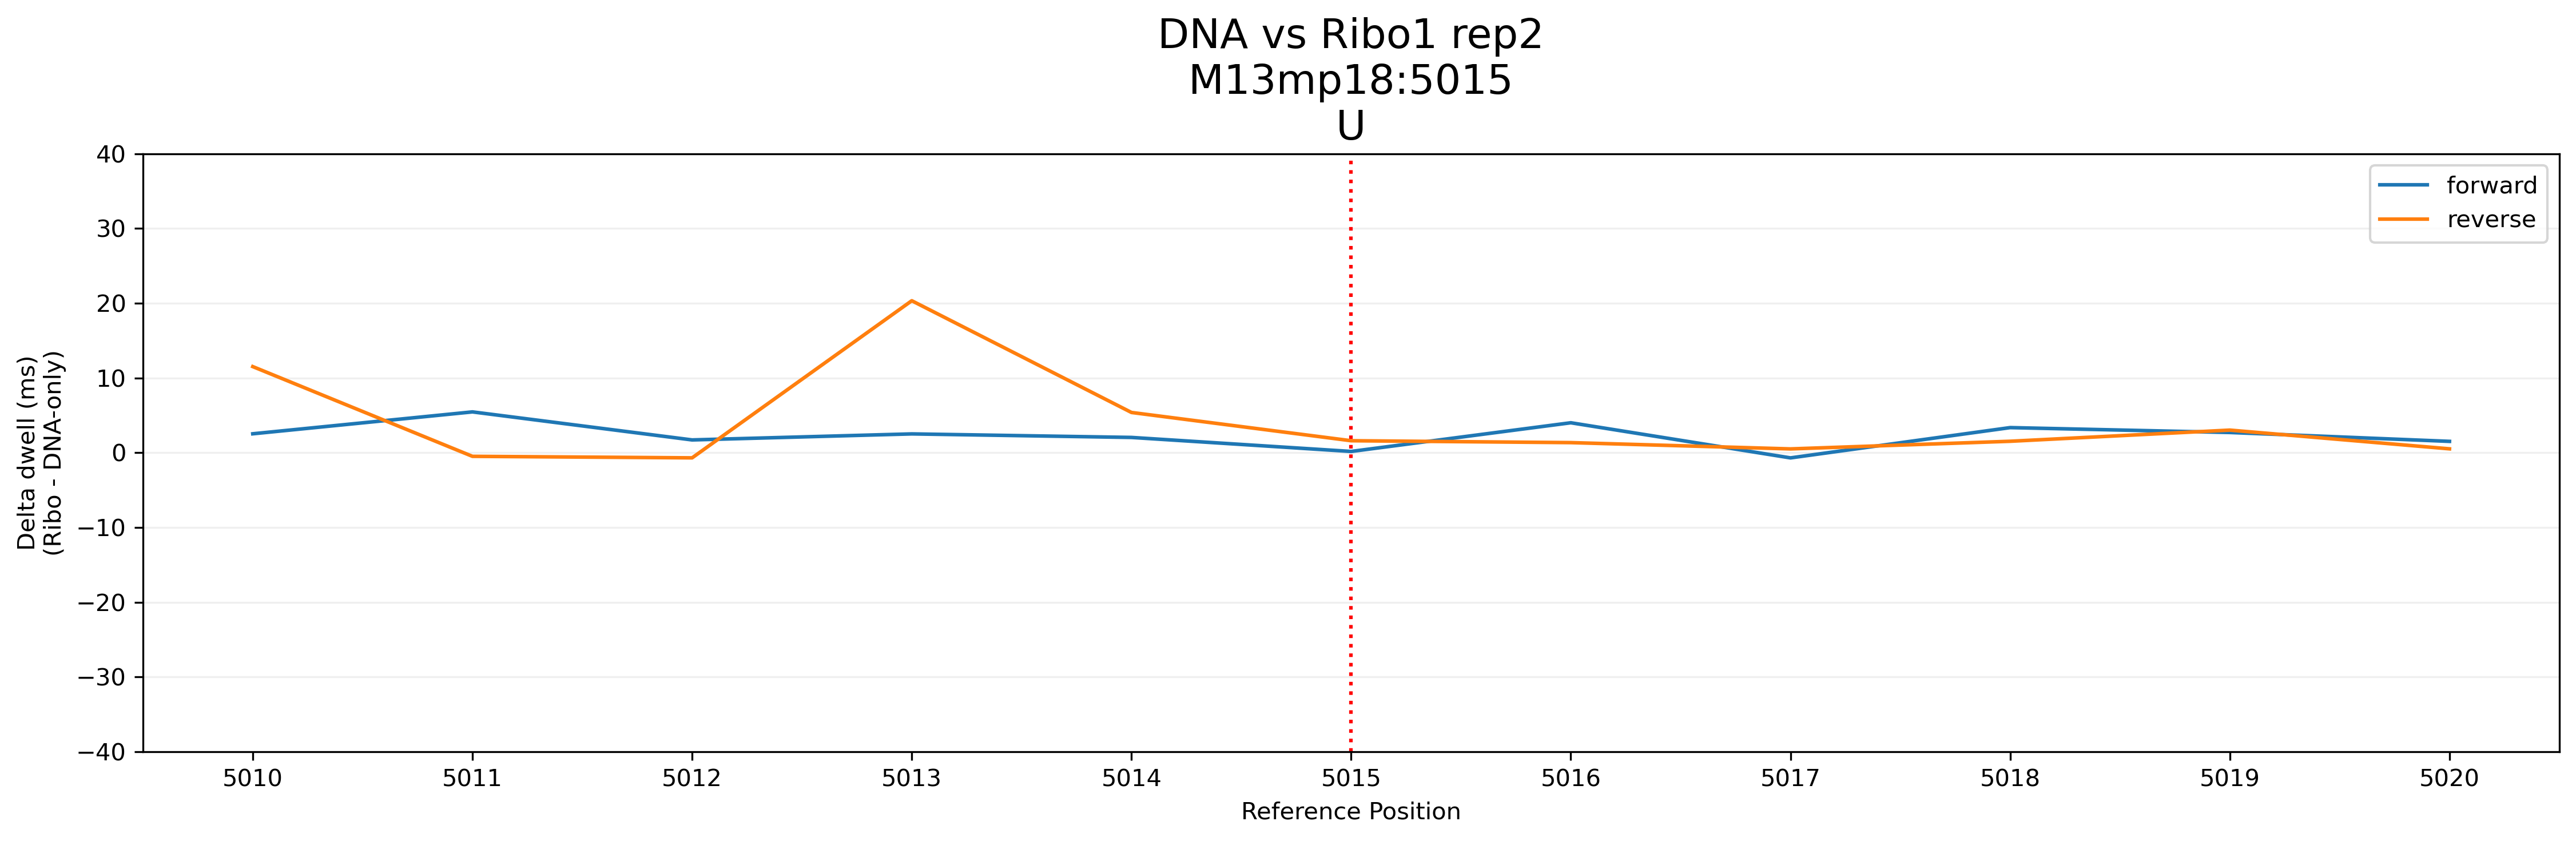

In [11]:
# produce differenial plot for dwell time
comparison_title = "DNA vs Ribo1 rep2"
labels = ["DNA-only", "Ribo1-rep2"]

# define expected sites with ribonucleotides insertion on reverse strand
sites = [4985, 4997, 5004, 5015]

# define ribo names into a list
ribos = ["rA", "rG", "rC", "U"]

# load stats tables
df_for = pd.read_table(os.path.join(results_folder_path, comparison_title+".dwell_stats.forw.tsv"), index_col=0)
df_for = df_for.iloc[:,[0,2,10]]
df_for["delta_forw"] = df_for.iloc[:,2] - df_for.iloc[:,1]

df_rev = pd.read_table(os.path.join(results_folder_path, comparison_title+".dwell_stats.rev.tsv"), index_col=0)
df_rev = df_rev.iloc[:,[0,2,10]]
df_rev["delta_rev"] = df_rev.iloc[:,2] - df_rev.iloc[:,1]

df_delta_global = pd.merge(df_for[["position", "delta_forw"]], df_rev[["position", "delta_rev"]], how="inner", on="position")

for site, ribo in zip(sites, ribos):
    print(site, ribo)
    interval = 5
    start = site - interval
    stop = site + interval
    title = comparison_title
    suptitle = f"M13mp18:{site}"
    df_delta = df_delta_global.query(f"position >= {start} and position <= {stop}")
    # plot resulting delta plot
    f = plt.figure(figsize=(15,5), dpi=300)
    plt.plot(df_delta["position"], df_delta["delta_forw"], label="forward")
    plt.plot(df_delta["position"], df_delta["delta_rev"], label="reverse")
    plt.legend()
    plt.title(comparison_title + "\n" + suptitle + "\n" + ribo, fontsize="xx-large")
    plt.xlabel("Reference Position")
    plt.ylabel("Delta dwell (ms)\n(Ribo - DNA-only)")
    plt.tight_layout()
    plt.xticks(np.arange(df_delta.position.min(), df_delta.position.max()+1,1))
    plt.ylim(-40, +40)
    # plot vline for ribo
    plt.vlines(site, -40, +40, linestyles="dotted", color="red")
    plt.grid(axis='y', alpha=0.2)
    # save to tiff
    plt.savefig(os.path.join(results_folder_path, f"{title}-{suptitle}.delta.tiff"), 
                    dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()